In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm

import re
import gensim

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# import nltk
# nltk.download('vader_lexicon')

In [2]:
sid = SentimentIntensityAnalyzer()
df = pd.read_csv("p_skytrax.csv")

In [3]:
# get the polarity scores and parse them to different columns
df['scores'] = df['cleaned_body'].apply(lambda review: sid.polarity_scores(review))

df['pos_score']  = df['scores'].apply(lambda score_dict: score_dict['pos'])
df['neu_score']  = df['scores'].apply(lambda score_dict: score_dict['neu'])
df['neg_score']  = df['scores'].apply(lambda score_dict: score_dict['neg'])
df['compound_score']  = df['scores'].apply(lambda score_dict: score_dict['compound'])
df.to_csv("sent_skytrax.csv")

In [8]:
# extract the reviews, rating and scores columns to separate df
col_names = ['cleaned_body', 'pos_score', 'neu_score', 'neg_score', 'compound_score', 'rating']
review_df = df[col_names]
review_df.to_csv("reviews_scores.csv")

In [9]:
# scale the compound score
def scale_compound_score(scores, mi = min(review_df["compound_score"]),ma = max(review_df["compound_score"]) ):
    return (scores["compound_score"] - mi) / (ma - mi)

review_df["cs_scaled"] = review_df.apply(scale_compound_score,axis=1)

/var/folders/y_/ff7_m0c146ddrr_mctd4vpkh0000gn/T/ipykernel_71534/2125841316.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df["cs_scaled"] = review_df.apply(scale_compound_score,axis=1)


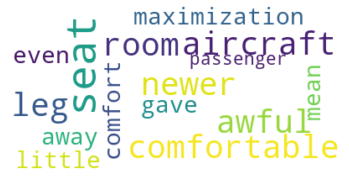

pos_score 0.256
neu_score 0.604
neg_score 0.139
compound_score 0.3626


In [7]:
# view an instance of the review
review = review_df.loc[0] 

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(review["cleaned_body"])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

print("pos_score",review["pos_score"])
print("neu_score",review["neu_score"])
print("neg_score",review["neg_score"])
print("compound_score",review["compound_score"])

In [11]:
# classify the review based on compound score
def get_sentiment(scores, threshold=0.05):
    val = "neutral"
    if scores["compound_score"] > threshold:
        val = "positive"
    elif scores["compound_score"] < -threshold:
        val = "negative"
    return val


review_df["sentiment"] = review_df.apply(get_sentiment,axis=1)

/var/folders/y_/ff7_m0c146ddrr_mctd4vpkh0000gn/T/ipykernel_71534/2966427546.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df["sentiment"] = review_df.apply(get_sentiment,axis=1)


<AxesSubplot:>

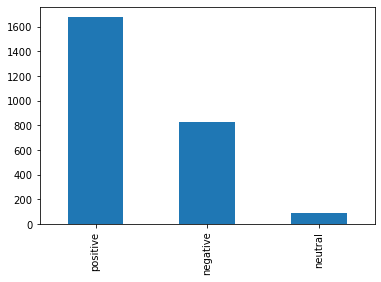

In [9]:
review_df["sentiment"].value_counts().plot(kind='bar')

In [10]:
# check the correlation between rating and the score predicted by the model
corr_values = review_df[["rating","cs_scaled"]].dropna(axis=0).corr()
corr_values

,rating,cs_scaled
rating,1.000000,0.626758
cs_scaled,0.626758,1.000000


In [11]:
# Extract only the negative reviews
negative_reviews = review_df[review_df.sentiment == "negative"]
negative_reviews.to_csv("negative_reviews.csv")
negative_reviews.head()

,cleaned_body,pos_score,neu_score,neg_score,compound_score,rating,cs_scaled,sentiment
3,discovered upon boarding four year old allocat...,0.113,0.726,0.161,-0.5267,0.1,0.229239,negative
7,good choose airasia flight le hour distance se...,0.114,0.747,0.139,-0.2978,0.4,0.345074,negative
19,seat dirty torn inflight entertainment food se...,0.064,0.570,0.366,-0.8815,0.2,0.049694,negative
29,told china eastern airline disabled double tot...,0.090,0.814,0.096,-0.1280,0.4,0.431000,negative
33,icn pvg lhr cdg pvg icn sat near lavatory make...,0.103,0.658,0.239,-0.5106,0.1,0.237387,negative
